<a href="https://colab.research.google.com/github/Malleshcr7/AI-ML-Projects/blob/main/Face_recognition_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time Face Recognition System for Google Colab


## Install required packages
Run this cell once at the start to install libraries needed for face recognition and image handling.


In [ ]:
!pip install opencv-python
!pip install cmake
!pip install dlib
!pip install face_recognition

## Imports and utilities
Imports libraries used across the notebook and sets up commonly used modules.


Saving test1.png to test1.png


Saving test2.png to test2.png


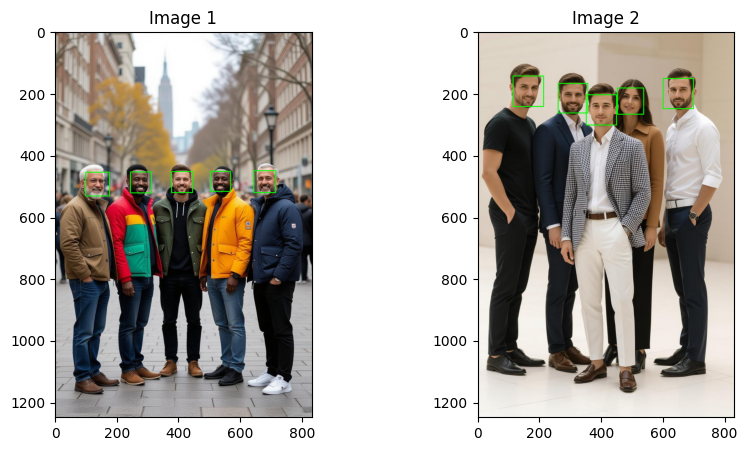

In [1]:
import cv2
import numpy as np
from google.colab import files

# Upload first image
uploaded1 = files.upload()
img1 = cv2.imdecode(np.frombuffer(list(uploaded1.values())[0], np.uint8), cv2.IMREAD_COLOR)

# Upload second image
uploaded2 = files.upload()
img2 = cv2.imdecode(np.frombuffer(list(uploaded2.values())[0], np.uint8), cv2.IMREAD_COLOR)

# Convert images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces
faces1 = face_cascade.detectMultiScale(gray1, scaleFactor=1.1, minNeighbors=5)
faces2 = face_cascade.detectMultiScale(gray2, scaleFactor=1.1, minNeighbors=5)

# Draw rectangles around faces
for (x, y, w, h) in faces1:
    cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), 2)

for (x, y, w, h) in faces2:
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.show()